### Import packages

In [1]:
import os
import pathlib
import rasterio
import numpy as np
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
from math import cos, radians

### Define paths

In [2]:
# Paths
base = pathlib.Path().resolve()

result_dir = base / "result"
processed_dir = result_dir / "processed"



decade_paths = {
    "2010–2020": processed_dir / "rhodolith_prediction_2010_2020.tif",
    "2020–2030": processed_dir / "rhodolith_prediction_2020_2030.tif",
    "2030–2040": processed_dir / "rhodolith_prediction_2030_2040.tif",
    "2040–2050": processed_dir / "rhodolith_prediction_2040_2050.tif",
    "2050–2060": processed_dir / "rhodolith_prediction_2050_2060.tif",
    "2060–2070": processed_dir / "rhodolith_prediction_2060_2070.tif",
    "2070–2080": processed_dir / "rhodolith_prediction_2070_2080.tif",
    "2080–2090": processed_dir / "rhodolith_prediction_2080_2090.tif",
    "2090–2100": processed_dir / "rhodolith_prediction_2090_2100.tif",
}

### Filter to threshold

In [3]:
# Set threshold for habitat suitability
threshold = 0.8  # values equal to or above this are considered suitable

# Process each rhodolith prediction raster
for tif_path in result_dir.glob("rhodolith_prediction_*.tif"):  # loop through all prediction rasters
    print(f"Processing: {tif_path.name}")

    with rasterio.open(tif_path) as src:  # open the raster file
        arr = src.read(1)  # read the first band as a NumPy array
        meta = src.meta.copy()  # copy metadata for writing

        # Generate binary raster:
        # 1 for suitable areas, 255 for non-suitable (used as NoData)
        binary = np.where(arr >= threshold, 1, 255).astype(np.uint8)

        # Update metadata for binary output
        meta.update({
            "dtype": "uint8",
            "nodata": 255,
            "count": 1
        })

    # Define output path and save the binary raster
    out_path = processed_dir / tif_path.name  # define output filename
    with rasterio.open(out_path, "w", **meta) as dest:  # write binary raster
        dest.write(binary, 1)

    print(f"Saved: {out_path.name}")  # confirm save


Processing: rhodolith_prediction_2010_2020.tif
Saved: rhodolith_prediction_2010_2020.tif
Processing: rhodolith_prediction_2020_2030.tif
Saved: rhodolith_prediction_2020_2030.tif
Processing: rhodolith_prediction_2030_2040.tif
Saved: rhodolith_prediction_2030_2040.tif
Processing: rhodolith_prediction_2040_2050.tif
Saved: rhodolith_prediction_2040_2050.tif
Processing: rhodolith_prediction_2050_2060.tif
Saved: rhodolith_prediction_2050_2060.tif
Processing: rhodolith_prediction_2060_2070.tif
Saved: rhodolith_prediction_2060_2070.tif
Processing: rhodolith_prediction_2070_2080.tif
Saved: rhodolith_prediction_2070_2080.tif
Processing: rhodolith_prediction_2080_2090.tif
Saved: rhodolith_prediction_2080_2090.tif
Processing: rhodolith_prediction_2090_2100.tif
Saved: rhodolith_prediction_2090_2100.tif


### Estimate area

,Decade,Suitable Pixels,Area (km²),Area (m²),Change from 2010s,% Change from 2010s
0,2010–2020,20820,261011.216851,2.610112e+11,0,0.000000
1,2020–2030,19697,238885.501824,2.388855e+11,-1123,-5.393852
2,2030–2040,8355,101573.024003,1.015730e+11,-12465,-59.870317
3,2040–2050,8251,108235.987329,1.082360e+11,-12569,-60.369837
4,2050–2060,5826,72616.051701,7.261605e+10,-14994,-72.017291
5,2060–2070,6647,83820.889879,8.382089e+10,-14173,-68.073967
6,2070–2080,6018,76082.101151,7.608210e+10,-14802,-71.095101
7,2080–2090,5637,69851.037222,6.985104e+10,-15183,-72.925072
8,2090–2100,5109,62122.731425,6.212273e+10,-15711,-75.461095


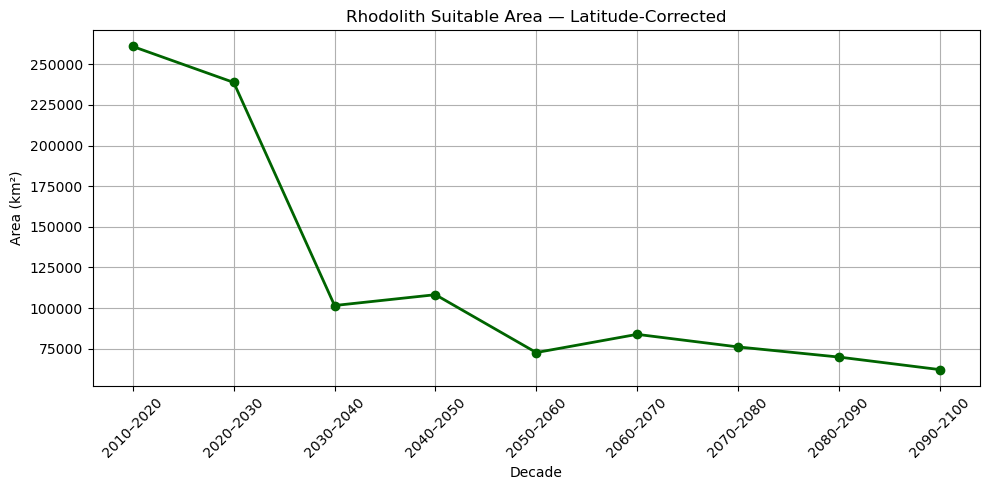

In [4]:
# Function to estimate the area of a pixel in km² at a given latitude
def estimate_pixel_area(lat, res_deg=0.05):
    R = 6371  # Earth's radius in kilometers
    dx = res_deg * (2 * np.pi * R / 360) * cos(radians(lat))  # pixel width (longitude component)
    dy = res_deg * (2 * np.pi * R / 360)  # pixel height (latitude component)
    return dx * dy  # return area in km²

# Function to count suitable pixels and calculate total area
def count_suitable_area(path):
    with rasterio.open(path) as src:  # open raster file
        data = src.read(1)  # read first band
        transform = src.transform  # get affine transform

        # Identify indices of suitable pixels (value = 1)
        rows, cols = np.where(data == 1)

        total_area_km2 = 0  # initialize total area
        for row in rows:
            lat = src.xy(row, 0)[1]  # get latitude of pixel center
            pixel_area = estimate_pixel_area(lat)  # compute pixel area
            total_area_km2 += pixel_area  # accumulate area

        return len(rows), total_area_km2, total_area_km2 * 1e6  # return counts and area in m²

# Initialize list for results and variable for baseline comparison
results = []
baseline_pixels = None  # used to compare with first time step

# Loop through all prediction rasters per decade
for decade, path in decade_paths.items():
    suitable_pixels, area_km2, area_m2 = count_suitable_area(path)  # compute stats

    if baseline_pixels is None:  # set baseline from the first period
        baseline_pixels = suitable_pixels

    change = suitable_pixels - baseline_pixels  # absolute change
    percent_change = 100 * change / baseline_pixels if baseline_pixels else np.nan  # relative change

    results.append({
        "Decade": decade,
        "Suitable Pixels": suitable_pixels,
        "Area (km²)": area_km2,
        "Area (m²)": area_m2,
        "Change from 2010s": change,
        "% Change from 2010s": percent_change
    })

# Convert results to DataFrame and display
summary_df = pd.DataFrame(results)
display(summary_df)

# Plot suitable area over time
plt.figure(figsize=(10, 5))
plt.plot(summary_df["Decade"], summary_df["Area (km²)"],
         marker='o', linewidth=2, color='darkgreen')
plt.title("Rhodolith Suitable Area — Latitude-Corrected")
plt.ylabel("Area (km²)")
plt.xlabel("Decade")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
